# ECCITE ChIP-seq Analysis

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import itertools
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline

In [196]:
pd.set_option('display.max_rows', 500)
pd.set_option('max_columns', None)

In [3]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [4]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

In [5]:
data_path = '/data_volume/memento/eccite/'

### Read the guide labled perturb-seq data

From perturbseq paper

In [6]:
adata = sc.read(data_path + 'eccite.h5ad')
adata.var.index.name=None

In [7]:
# guides = adata.obs.guides.drop_duplicates().tolist()
# guides = [g for g in guides if ('INTER' not in g and 'nan' not in g)]
# ko_genes = adata.obs.query('KO == 1')['KO_GENE'].drop_duplicates().tolist()

### Setup memento

In [8]:
adata.obs['q'] = 0.15

In [10]:
memento.setup_memento(adata, q_column='q', filter_mean_thresh=0.07)

Version 0.0.6


/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:70: RankWarning: Polyfit may be poorly conditioned
  all_res_var = estimator._residual_variance(all_m, all_v, estimator._fit_mv_regressor(all_m, all_v))


In [11]:
ko_genes = adata.obs.gene.drop_duplicates().tolist()

### Get ENCODE data

In [234]:
encode_meta = pd.read_csv('encode/metadata (4).tsv', sep='\t')

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (13,14,15,16,20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [304]:
filtered_encode_meta = encode_meta[encode_meta['File format'] == "bed narrowPeak"]\
    .sort_values('Output type')
filtered_encode_meta = filtered_encode_meta[filtered_encode_meta['Output type'].isin(['optimal IDR thresholded peaks'])]\
    .sort_values('Output type', ascending=False)
filtered_encode_meta = filtered_encode_meta[filtered_encode_meta['File assembly']=='GRCh38']
# filtered_encode_meta = filtered_encode_meta[filtered_encode_meta['Audit NOT_COMPLIANT'].isnull()]

In [305]:
filtered_encode_meta.shape

(637, 58)

In [306]:
filtered_encode_meta['Output type'].value_counts()

optimal IDR thresholded peaks    637
Name: Output type, dtype: int64

In [307]:
enc = encode.Encode('/home/ssm-user/Github/misc-seq/miscseq/GRCh38Genes.bed')

In [308]:
genes_of_interest = ['STAT1']

In [311]:
chip_genes = {}
for g in genes_of_interest:
    encode_rows = filtered_encode_meta[filtered_encode_meta['Experiment target'].str.contains(g)]
    urls = encode_rows['File download URL'].tolist()
    
    bed = enc.get_encode_peaks_union(urls)
    chip_genes[g] = enc.get_peak_genes_bed(bed, 0).query('distance == 0').gene.tolist()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python

In [67]:
a = None
for tf, val in chip_genes.items():
    
    if a is None:
        a = pd.DataFrame(index=val)
        a[tf] = 1
    else:
        b = pd.DataFrame(index=val)
        b[tf] = 1
        a = a.join(b, how='outer')
    
all_chip_result = a.fillna(0)
all_chip_result.to_csv('all_chip_result.csv')

### Analyze 1D

In [82]:
results = {}
for g in ko_genes:
    if g == 'NT': continue
    print(g)
    subset = sc.read(data_path +'1d/{}.h5ad'.format(g))
    df = memento.get_1d_ht_result(subset)
    df['de_fdr'] = memento.util._fdrcorrect(df['de_pval'])
    df['dv_fdr'] = memento.util._fdrcorrect(df['dv_pval'])
    results[g] = df.copy()

STAT2
CAV1
STAT1
CD86
IRF7
ATF2
STAT3
JAK2
NFKBIA
SMAD4
STAT5A
CMTM6
IFNGR1
UBE2L6
PDCD1LG2
CUL3
BRD4
MARCH8
IRF1
POU2F2
ETV7
IFNGR2
TNFRSF14
SPI1
MYC


In [147]:
for g in ko_genes:
    if g == 'NT': continue
    print(
        g, 
        results[g].query('dv_fdr < 0.1').shape[0],
        results[g].query('de_fdr < 0.1').shape[0]
        )

STAT2 17 276
CAV1 0 0
STAT1 404 3530
CD86 0 0
IRF7 0 0
ATF2 0 0
STAT3 2 0
JAK2 414 4280
NFKBIA 0 0
SMAD4 365 3586
STAT5A 0 0
CMTM6 0 1
IFNGR1 323 4149
UBE2L6 2 0
PDCD1LG2 0 0
CUL3 0 561
BRD4 1 1552
MARCH8 0 0
IRF1 37 1834
POU2F2 0 0
ETV7 0 0
IFNGR2 402 4316
TNFRSF14 0 0
SPI1 389 0
MYC 0 181


In [197]:
results['STAT1'].sort_values('dv_coef', ascending=False)['dv_coef']

3009    2.307378
1472    2.180096
3051    2.143336
447     2.142247
6526    2.119310
          ...   
2691   -2.716775
758    -2.906743
6062   -3.667501
3085   -3.806678
4780   -4.058508
Name: dv_coef, Length: 9112, dtype: float64

In [78]:
tf_count = all_chip_result.sum(axis=1).reset_index(name='count').rename(columns={'index':'gene'})

In [192]:
all_chip_result.loc['SCYL3', 'STAT1']

1.0

In [292]:
len(chip_genes['STAT1'])

6618

In [293]:
tf_result['TFBS'].mean()

0.5024056723221069

In [312]:
tf = 'STAT1'
tf_result = results[tf].copy().merge(tf_count, on='gene')
tf_result['dv_sig'] = (tf_result['dv_fdr'] < 0.1) &(tf_result['dv_coef'] < 0)
tf_result['TFBS'] = tf_result.gene.isin(chip_genes[tf])

In [313]:
print(pd.crosstab(tf_result.query('de_fdr > 0.2')['dv_sig'], tf_result.query('de_fdr > 0.2')['TFBS']))
stats.chi2_contingency(pd.crosstab(tf_result['dv_sig'], tf_result['TFBS']))

TFBS    False  True 
dv_sig              
False    2473   1591
True       62     36


(0.25948403817352567,
 0.6104748491980349,
 1,
 array([[4611.71182578, 3048.28817422],
        [ 143.28817422,   94.71182578]]))

<AxesSubplot:xlabel='dv_sig', ylabel='count'>

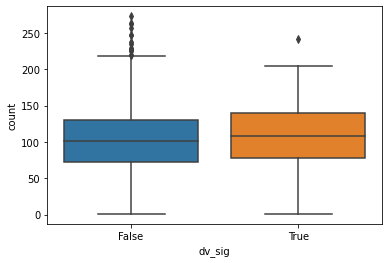

In [171]:
sns.boxplot(x='dv_sig', y='count', data=tf_result.query('TFBS'))

In [84]:
tf_result

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,de_fdr,dv_fdr,count
0,NOC2L,0.381037,0.094519,2.948419e-04,0.633284,0.596108,0.269473,0.002427,0.674756,81.0
1,ISG15,-1.068111,0.063165,1.673126e-07,1.448881,0.139218,0.000012,0.000090,0.003182,114.0
2,AGRN,-0.197106,0.168421,2.415758e-01,0.084745,0.479359,0.855914,0.398920,0.969043,32.0
3,SDF4,0.012148,0.039725,7.606239e-01,-0.035777,0.190202,0.848815,0.855655,0.967100,130.0
4,B3GALT6,0.217468,0.135431,1.070893e-01,-0.179123,0.495406,0.702030,0.219527,0.924938,37.0
...,...,...,...,...,...,...,...,...,...,...
7893,MT-ND4L,0.061337,0.027795,2.889711e-02,-0.299408,0.115755,0.009999,0.079406,0.154950,1.0
7894,MT-ND4,0.087957,0.026996,1.292399e-03,-0.275248,0.108905,0.010899,0.006957,0.162538,2.0
7895,MT-ND5,0.054412,0.030597,7.159284e-02,-0.282663,0.103028,0.007399,0.161394,0.132460,1.0
7896,MT-ND6,0.038268,0.056769,5.041496e-01,-0.268515,0.139125,0.051695,0.655978,0.329631,1.0


In [ ]:
results['']

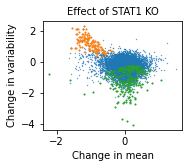

In [28]:
plt.figure(figsize=(2.5,2))
plt.scatter(results['STAT1']['de_coef'], results['STAT1']['dv_coef'], s=0.1)
plt.title('Effect of STAT1 KO');
plt.xlabel('Change in mean'); plt.ylabel('Change in variability')
plt.scatter(results['STAT1'].query('dv_fdr < 0.1 & dv_coef > 0')['de_coef'], results['STAT1'].query('dv_fdr < 0.1 & dv_coef > 0')['dv_coef'], s=1)
plt.scatter(results['STAT1'].query('dv_fdr < 0.1 & dv_coef < 0')['de_coef'], results['STAT1'].query('dv_fdr < 0.1 & dv_coef < 0')['dv_coef'], s=1)

plt.savefig('figures/variability.png', bbox_inches='tight', dpi=800)

In [32]:
results['STAT1'].query('dv_fdr < 0.1 & dv_coef < 0').sort_values('dv_coef').sort_values('dv_coef').head(50)

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,de_fdr,dv_fdr
4780,MAN1B1,0.250966,0.095819,0.010399,-4.058508,0.365175,0.000002,0.035476,0.001055
3085,TBCC,0.074286,0.120828,0.536946,-3.806678,0.673382,0.000238,0.684383,0.019164
6062,SNRNP35,-0.079500,0.131270,0.544846,-3.667501,0.698823,0.000242,0.692031,0.019330
758,SCYL3,-0.286684,0.149177,0.052395,-2.906743,0.595175,0.000499,0.126570,0.032225
2691,SLC22A5,0.290712,0.221457,0.181382,-2.716775,0.445824,0.000068,0.324897,0.008286
6302,PCK2,-0.228575,0.127458,0.072593,-2.667838,0.309702,0.000018,0.163003,0.003397
8882,NOL12,0.164642,0.107262,0.124988,-2.659819,0.617985,0.001200,0.246833,0.053595
1584,USP40,-0.050558,0.176293,0.770723,-2.627097,0.431096,0.000110,0.862132,0.011388
8730,ZNF581,-0.033697,0.129883,0.794621,-2.595223,0.573502,0.001600,0.878838,0.057620
1928,UMPS,0.155117,0.155334,0.316568,-2.594304,0.515781,0.000255,0.481645,0.019994


In [17]:
for g in results['STAT1'].query('dv_fdr < 0.1 & dv_coef < 0').gene.tolist():
    print(g)

RPL22
CLSTN1
SRM
CROCCP2
STMN1
SH3BGRL3
SPOCD1
MARCKSL1
MFSD2A
SMAP2
ATP6V0B
RPS8
ALG6
DEPDC1
LRRC40
RPL5
CYB561D1
ENSA
S100A10
S100A13
CKS1B
LMNA
TAGLN2
SFT2D2
SCYL3
ABL2
RGS1
NUCKS1
PTPN14
CENPF
CAPN2
ENAH
OST4
CDC42EP3
MCFD2
RPS27A
MXD1
BOLA3
IL1B
TNFAIP6
SLC25A12
DNAJC10
EEF1B2
SLC11A1
USP40
HES6
GPR35
THUMPD3
VHL
RPL32
SH3BP5
ANKRD28
SGOL1
RPSA
CCDC12
GPX1
MON1A
RPL29
RPL24
UMPS
CHCHD6
LEKR1
AC093323.3
BLOC1S4
RBPJ
IL8
HNRNPDL
LARP7
CCNA2
TDO2
GPBP1
CCNB1
NAIP
HMGCR
RPS23
ST8SIA4
YTHDC2
HINT1
SLC22A5
TGFBI
RBM27
CSF1R
RPS14
GEMIN5
PTTG1
RNF130
GNB2L1
CLIC1
RPS18
HMGA1
TREM2
TBCC
COX7A2
IRAK1BP1
HMGN3-AS1
TTK
AKIRIN2
BCLAF1
FSCN1
NT5C3A
UBE2D4
TBRG4
IGFBP3
UPP1
CHCHD2
TP53TG1
ARPC1B
AC002467.7
ATP6V1F
C7orf73
GPKOW
PLP2
RPS4X
UBE2A
MTM1
CTSB
TCEA1
RPL7
MTDH
MYC
RPL8
RPS6
UNC13B
TESK1
CKS2
IARS
DNAJC25
RPL35
RPL12
AGPAT2
MAN1B1
NDOR1
KLF6
NET1
ARHGAP12
CDK1
RPS24
ANXA11
CEP55
RRP12
MKI67
RPLP2
C11orf74
SLC43A1
MS4A7
MS4A14
C11orf24
RPS3
DDX6
A2M
OLR1
YBX3
CCDC91
HDAC7
SHMT2
CAND1
GL

### Run coexpression

In [36]:
for g in ko_genes:
    
    subset = adata.copy().copy()
    
    subset.obs['is_ko'] = subset.obs.guide_ID.str.contains(g).values
    
    memento.create_groups(subset, label_columns=['is_ko', 'replicate'])
    
    memento.compute_1d_moments(subset, min_perc_group=.7)
    
    available_tfs = list(set(subset.var.index) & set(ko_genes))
    available_genes = list(set(subset.var.index) - set(ko_genes))
    
    print(len(available_tfs), len(available_genes))
    memento.compute_2d_moments(subset, list(itertools.product(available_tfs, available_genes))   )
    
    memento.ht_2d_moments( 
        subset, 
        formula_like='1 + is_ko + replicate',
        treatment_col='is_ko', 
        num_boot=10000, 
        verbose=1,
        num_cpus=94,
        resampling='permutation',
        approx=False)
    subset.write(data_path + '2d/{}.h5ad'.format(g))
    
    break

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


23 9137


KeyboardInterrupt: 

In [18]:
df = memento.get_1d_ht_result(subset)

In [19]:
df['de_fdr'] = memento.util._fdrcorrect(df['de_pval'])
df['dv_fdr'] = memento.util._fdrcorrect(df['dv_pval'])

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='de_coef', ylabel='Density'>

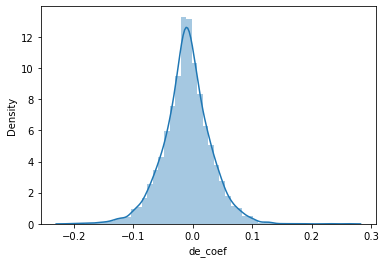

In [70]:
sns.distplot(df['de_coef'])

In [71]:
df['dv_pval'].min()

0.00027310807688639584

In [79]:
filtered_df = df.query('dv_coef > 0.6 | dv_coef < -0.6').copy()
filtered_df['de_fdr'] = memento.util._fdrcorrect(filtered_df['de_pval'])
filtered_df['dv_fdr'] = memento.util._fdrcorrect(filtered_df['dv_pval'])

In [80]:
filtered_df.sort_values('de_fdr')

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,de_fdr,dv_fdr
2590,Appl1,-0.189303,0.062989,0.002653,-1.045370,0.893075,0.241789,0.570382,0.267774
2637,Ngdn,0.066474,0.038300,0.082629,-0.619962,0.197640,0.001708,0.683281,0.082191
1008,Zdhhc21,0.098259,0.052358,0.060562,0.642448,0.372952,0.084961,0.683281,0.161127
3867,Gm5483,-0.191321,0.097545,0.049838,-1.226904,0.870802,0.158854,0.683281,0.201676
3749,Twf1,-0.067900,0.039066,0.082196,0.784043,0.227191,0.000558,0.683281,0.082191
...,...,...,...,...,...,...,...,...,...
3738,Atxn10,-0.001235,0.042985,0.977087,0.636208,0.307657,0.038648,0.984020,0.147004
2713,4931406C07Rik,-0.001389,0.053892,0.979443,0.796920,0.569918,0.162021,0.984020,0.202527
2904,Ndufaf3,0.002372,0.044915,0.957888,0.718853,0.393524,0.067744,0.984020,0.150387
261,Phyh,0.002676,0.060083,0.964480,0.724015,0.511069,0.156580,0.984020,0.201586


In [72]:
df.sort_values('dv_pval')

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,de_fdr,dv_fdr
3617,Dab2,-0.009180,0.030172,0.760938,-0.560985,0.154136,0.000273,0.982760,0.797630
3749,Twf1,-0.067900,0.039066,0.082196,0.784043,0.227191,0.000558,0.862292,0.797630
3618,Fyb,0.003404,0.032799,0.917338,0.430096,0.132779,0.001199,0.988550,0.797630
803,Ubap2l,0.032034,0.027460,0.243391,0.798079,0.248173,0.001301,0.907900,0.797630
820,S100a11,0.016178,0.012787,0.205789,0.135432,0.042790,0.001551,0.907900,0.797630
...,...,...,...,...,...,...,...,...,...
3528,Arf6,-0.033421,0.026366,0.204944,0.000226,0.147194,0.998776,0.907900,0.999479
2287,Tmbim4,0.013307,0.026034,0.609262,0.000183,0.141843,0.998969,0.966870,0.999479
370,Gca,0.150333,0.149174,0.313564,-0.000617,0.517727,0.999049,0.911683,0.999479
87,Wdfy1,-0.145767,0.048090,0.002436,-0.000196,0.209772,0.999254,0.654695,0.999479


(array([511., 503., 498., 436., 449., 420., 400., 459., 361., 404.]),
 array([2.73108077e-04, 1.00213367e-01, 2.00153626e-01, 3.00093885e-01,
        4.00034145e-01, 4.99974404e-01, 5.99914663e-01, 6.99854922e-01,
        7.99795181e-01, 8.99735440e-01, 9.99675699e-01]),
 <BarContainer object of 10 artists>)

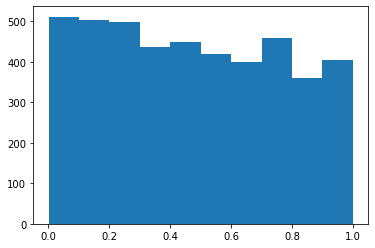

In [69]:
plt.hist(df['dv_pval'])